In [6]:
import numpy as np
np.set_printoptions(suppress=True)
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
plt.style.use('seaborn-white')

<ipython-input-6-6d0fa4db7acd>:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


In [7]:
import morl
from env_LQG import LQG

In [8]:
SIGMA = 1.0

# Optimal PF

n_repeat=2000

In [11]:
%%time
from optimal_lqg_solver import MO_LQG_return

ws = np.arange(0.01, 1, 0.01)
ws = np.hstack([ws.reshape(-1, 1), 1 - ws.reshape(-1, 1)])

opt_Rs = np.asarray([MO_LQG_return(xi=0.1, gamma=0.9, w=w, x_init=[10.0]*2, 
                                   n_repeat=2000, T_horizon=30, noise_std=SIGMA)
         for w in ws])

CPU times: user 2min 34s, sys: 16.7 s, total: 2min 51s
Wall time: 2min 31s


In [14]:
with open('lqg_2d_noisy_opt_Rs.pkl', 'wb') as f:
    pickle.dump(opt_Rs, f)

In [16]:
# optimal HV
morl.HV((opt_Rs - np.asarray([-310.0] * 2)) / (np.asarray([-150.0] * 2) - np.asarray([-310.0] * 2)), 
        ref_point=np.zeros(2))

0.9967124794541476

In [22]:
opt_Rs[[0, -1]]

array([[-288.45755272, -141.77077314],
       [-141.8383835 , -287.92743574]])

# LC-MOPGで学習

test_repeat=10

In [23]:
def main(n_obj: int, c_dim: int, n_rep: int, name: str = None):
    for i in range(1, 1 + n_rep):
        
        np.random.seed(i)
        
        policy = morl.make_policy_net(state_dim=n_obj, 
                                      hidden_dim=24, 
                                      act_space=('continuous', n_obj), 
                                      c_dim=c_dim, 
                                      seed=i,
                                      embed_dims=None, 
                                      std=0.2).to(morl.DEVICE)
        
        out = morl.learn(policy=policy, 
                         gradient_steps=500, 
                         n_grad_repeat=1, 
                         group_size_train=200, 
                         group_size_test=200, 
                         env=LQG(n_obj=n_obj, noise_std=SIGMA, a_max=11, normalizer=lambda x: x / 5.0 - 1.0), 
                         n_obj=n_obj, 
                         test_repeat=10, 
                         n_jobs=15, 
                         ep_len_train=30, 
                         ep_len_test=30, 
                         nn_k=3, 
                         beta=10.0, 
                         J_AU=np.asarray([-310.0] * n_obj), 
                         J_U=np.asarray([-150.0] * n_obj), 
                         gamma_train=0.9, 
                         gamma_test=0.9, 
                         mode='median', 
                         score_clipped_above_zero=True,
                         use_QV=False, 
                         QV_params=None
                        )
        if name is None:
            with open('out_{}.pkl'.format(i), 'wb') as f:
                pickle.dump(out, f)
        else:
            with open('out_{}_{}.pkl'.format(name, i), 'wb') as f:
                pickle.dump(out, f)

In [24]:
%%time
main(n_obj=2, n_rep=5, c_dim=2)

0 [0.08055] 1 [0.0] 2 [0.0] 3 [0.07101] 4 [0.0] 5 [0.0] 6 [0.0] 7 [0.1758] 8 [0.0] 9 [0.05154] 10 [0.0] 11 [0.05941] 12 [0.0] 13 [0.0] 14 [0.08699] 15 [0.08136] 16 [0.01365] 17 [0.0] 18 [0.0] 19 [0.0] 20 [0.0] 21 [0.0] 22 [0.168] 23 [0.0] 24 [0.0] 25 [0.001786] 26 [0.0] 27 [0.01945] 28 [0.0] 29 [0.3172] 30 [0.08103] 31 [0.0] 32 [0.08518] 33 [0.2716] 34 [0.0] 35 [0.0] 36 [0.0] 37 [0.03266] 38 [0.06251] 39 [0.1109] 40 [0.1413] 41 [0.03741] 42 [0.1408] 43 [0.2521] 44 [0.0] 45 [0.1221] 46 [0.315] 47 [0.01854] 48 [0.3246] 49 [0.1771] 50 [0.2236] 51 [0.1059] 52 [0.146] 53 [0.1063] 54 [0.1628] 55 [0.1924] 56 [0.2297] 57 [0.1156] 58 [0.2656] 59 [0.2237] 60 [0.1836] 61 [0.1693] 62 [0.2117] 63 [0.2326] 64 [0.07203] 65 [0.1083] 66 [0.2935] 67 [0.2188] 68 [0.2402] 69 [0.2847] 70 [0.2775] 71 [0.2793] 72 [0.3247] 73 [0.2517] 74 [0.2842] 75 [0.2875] 76 [0.2997] 77 [0.2785] 78 [0.2995] 79 [0.3492] 80 [0.2886] 81 [0.3707] 82 [0.37] 83 [0.2716] 84 [0.3713] 85 [0.3482] 86 [0.376] 87 [0.3488] 88 [0.3489] 

In [25]:
out = []
for i in range(1, 6):
    with open('out_{}.pkl'.format(i), 'rb') as f:
        out += [pickle.load(f)]

In [26]:
_o = np.asarray([out[i][0] for i in range(5)])

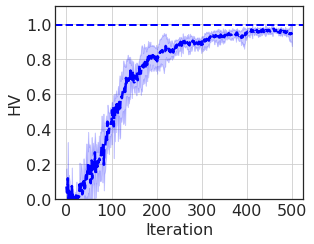

In [27]:
plt.figure(figsize=(4.6, 3.5))
plt.xticks(np.arange(0, 501, 100))
plt.ylim(0, 1.1)
plt.tick_params(labelsize=16)
plt.grid()
plt.ylabel('HV', fontsize=16)
plt.xlabel('Iteration', fontsize=16)
plt.axhline(0.9967124794541476, ls='--', c='b', lw=2)

plt.plot(_o.mean(axis=0), c='b', lw=2.5, ls='--')
plt.fill_between(np.arange(501), 
                 _o.mean(axis=0) - _o.std(axis=0), 
                 _o.mean(axis=0) + _o.std(axis=0), alpha=0.2, color='b')
plt.tight_layout()
# plt.savefig('learning_fruit_{}.png'.format(d_FTN), dpi=400)

In [28]:
# best policies
_oo = [out[i][2] for i in range(5)]

In [46]:
TEST_SIZE = 1500
REPEAT = 200

def func(i: int):
    cs, all_R = morl.group_evaluation_REPEAT(policy=_oo[i], 
                                             group_size=TEST_SIZE, 
                                             n_jobs=15, 
                                             env=LQG(n_obj=2, noise_std=SIGMA, a_max=11, 
                                                     normalizer=lambda x: x / 5.0 - 1.0).set_ep_len(30), 
                                             seed=1, deterministic=True, n_obj=2, gamma=0.9, 
                                             n_episode_repeat=REPEAT)

    return morl.HV(Rs=np.asarray(all_R), 
                   ref_point=np.asarray([-310.0] * 2)) / 160**2

In [47]:
%%time
from joblib import Parallel, delayed
peak_hv = Parallel(n_jobs=1)(delayed(func)(i) for i in range(5))

CPU times: user 32.9 s, sys: 3.92 s, total: 36.9 s
Wall time: 46min 10s


In [49]:
print(np.mean(peak_hv), np.std(peak_hv))

0.9616058230553749 0.003833180135395786


In [50]:
with open('eval_scores_1500_repeat=200.pkl', 'wb') as f:
    pickle.dump(peak_hv, f)

# Q と V を使用

test_repeat=10

In [43]:
def main_QV(n_obj: int, c_dim: int, n_rep: int, name: str = None):
    for i in range(1, 1 + n_rep):
        
        np.random.seed(i)
        
        policy = morl.make_policy_net(state_dim=n_obj, 
                                      hidden_dim=24, 
                                      act_space=('continuous', n_obj), 
                                      c_dim=c_dim, 
                                      seed=i,
                                      embed_dims=None, 
                                      std=0.2).to(morl.DEVICE)
        
        out = morl.learn(policy=policy, 
                         gradient_steps=500, 
                         n_grad_repeat=1, 
                         group_size_train=200, 
                         group_size_test=200, 
                         env=LQG(n_obj=n_obj, noise_std=SIGMA, a_max=11, normalizer=lambda x: x / 5.0 - 1.0), 
                         n_obj=n_obj, 
                         test_repeat=10, 
                         n_jobs=15, 
                         ep_len_train=30, 
                         ep_len_test=30, 
                         nn_k=3, 
                         beta=10.0, 
                         J_AU=np.asarray([-310.0] * n_obj), 
                         J_U=np.asarray([-150.0] * n_obj), 
                         gamma_train=0.9, 
                         gamma_test=0.9, 
                         mode='median', 
                         score_clipped_above_zero=False,    # no clipping
                         use_QV=True, 
                         QV_params={
                             'n_epochs': 1, 
                             'hidden_size': 24,
                             'batch_size': 64
                         }
                        )
        if name is None:
            with open('out_QV_{}.pkl'.format(i), 'wb') as f:
                pickle.dump(out, f)
        else:
            with open('out_QV_{}_{}.pkl'.format(name, i), 'wb') as f:
                pickle.dump(out, f)

In [48]:
%%time
main_QV(n_obj=2, n_rep=5, c_dim=2)

0 [0.0565] 1 [0.2666] 2 [0.253] 3 [0.3995] 4 [0.0] 5 [0.4799] 6 [0.3151] 7 [0.3668] 8 [0.03671] 9 [0.4867] 10 [0.5559] 11 [0.4598] 12 [0.2952] 13 [0.03434] 14 [0.2769] 15 [0.3302] 16 [0.4052] 17 [0.0] 18 [0.3071] 19 [0.2709] 20 [0.2917] 21 [0.3316] 22 [0.3136] 23 [0.01506] 24 [0.06321] 25 [0.1224] 26 [0.06147] 27 [0.002708] 28 [0.0] 29 [0.08419] 30 [0.0] 31 [0.0] 32 [0.08323] 33 [0.03073] 34 [0.01674] 35 [0.04113] 36 [0.02414] 37 [0.3089] 38 [0.1233] 39 [0.213] 40 [0.3259] 41 [0.4671] 42 [0.2823] 43 [0.4532] 44 [0.5092] 45 [0.5253] 46 [0.4802] 47 [0.5618] 48 [0.4526] 49 [0.5886] 50 [0.5573] 51 [0.4899] 52 [0.5406] 53 [0.5257] 54 [0.4892] 55 [0.524] 56 [0.4264] 57 [0.4857] 58 [0.4947] 59 [0.4951] 60 [0.4053] 61 [0.5065] 62 [0.4619] 63 [0.5028] 64 [0.6286] 65 [0.5318] 66 [0.6231] 67 [0.6562] 68 [0.6772] 69 [0.6477] 70 [0.7086] 71 [0.6927] 72 [0.6879] 73 [0.6814] 74 [0.6951] 75 [0.7626] 76 [0.5995] 77 [0.6514] 78 [0.6862] 79 [0.656] 80 [0.7201] 81 [0.7492] 82 [0.7042] 83 [0.7911] 84 [0.75

In [51]:
out_qv = []
for i in range(1, 6):
    with open('out_QV_{}.pkl'.format(i), 'rb') as f:
        out_qv += [pickle.load(f)]

In [52]:
_oqv = np.asarray([out_qv[i][0] for i in range(5)])

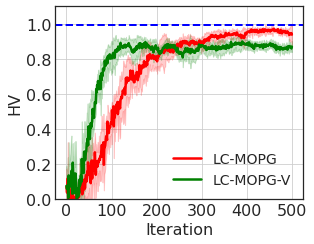

In [55]:
plt.figure(figsize=(4.6, 3.5))
plt.xticks(np.arange(0, 501, 100))
plt.ylim(0, 1.1)
plt.tick_params(labelsize=16)
plt.grid()
plt.ylabel('HV', fontsize=16)
plt.xlabel('Iteration', fontsize=16)

plt.plot(_o.mean(axis=0), c='r', lw=2.5, label='LC-MOPG')
plt.fill_between(np.arange(501), 
                 _o.mean(axis=0) - _o.std(axis=0), 
                 _o.mean(axis=0) + _o.std(axis=0), alpha=0.2, color='r')

plt.plot(_oqv.mean(axis=0), c='g', lw=2.5, label='LC-MOPG-V')
plt.fill_between(np.arange(501), 
                 _oqv.mean(axis=0) - _oqv.std(axis=0), 
                 _oqv.mean(axis=0) + _oqv.std(axis=0), alpha=0.2, color='g')

plt.axhline(0.9967124794541476, ls='--', c='b', lw=2)
plt.legend(fontsize=14)
plt.tight_layout()
# plt.savefig('learning_noisy_lqg_2d.png', dpi=400)

In [56]:
_ooqv = np.asarray([out_qv[i][2] for i in range(5)])

In [59]:
%%time
TEST_SIZE = 1500
REPEAT = 200
peak_qv_hv = []
for i in range(5):
    cs, all_R = morl.group_evaluation_REPEAT(policy=_ooqv[i], 
                                             group_size=TEST_SIZE, 
                                             n_jobs=15, 
                                             env=LQG(n_obj=2, noise_std=SIGMA, a_max=11, 
                                                     normalizer=lambda x: x / 5.0 - 1.0).set_ep_len(30), 
                                             seed=1, deterministic=True, n_obj=2, gamma=0.9, 
                                             n_episode_repeat=REPEAT)

    peak_qv_hv += [morl.HV(Rs=np.asarray(all_R), 
                           ref_point=np.asarray([-310.0] * 2)) / 160**2]

CPU times: user 33 s, sys: 2.89 s, total: 35.9 s
Wall time: 44min 48s


In [62]:
print(np.mean(peak_qv_hv), np.std(peak_qv_hv))

0.9143905864859704 0.02452805466285066


In [61]:
with open('eval(noisy)_scores_1500_repeat=200.pkl', 'wb') as f:
    pickle.dump(peak_qv_hv, f)